In [1]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Loading

In [2]:
raw_hmda = pd.read_csv('data/hmda_lar__smith_county__all_years.csv', dtype={
    'census_tract_number': 'str'
}, na_values=[
    'Not applicable',
    'Information not provided by applicant in mail, Internet, or telephone application'
])

tract_geos = gpd.read_file('data/tl_2017_48_tract')

raw_census = pd.read_csv('data/ACS_16_5YR_B03002/ACS_16_5YR_B03002.csv', dtype={
    'GEO.id2': 'str'
})

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (28,29,30,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Enrichment

In [3]:
enriched_hmda = raw_hmda.copy(deep=True)

enriched_hmda['log_loan_amount_000s'] = np.log(enriched_hmda['loan_amount_000s'])
enriched_hmda['log_applicant_income_000s'] = np.log(enriched_hmda['applicant_income_000s'])

def race_ethnicity(row):
    if row['applicant_ethnicity_name'] == 'Hispanic or Latino':
        return 'Latino'
    elif row['applicant_ethnicity_name'] == 'Not Hispanic or Latino':
        if row['applicant_race_name_1'] == 'White':
            return 'White'
        elif row['applicant_race_name_1'] == 'Black or African American':
            return 'Black'
        elif row['applicant_race_name_1'] == 'Asian':
            return 'Asian'
        elif row['applicant_race_name_1'] == 'American Indian or Alaska Native':
            return 'Native American'
        elif row['applicant_race_name_1'] == 'Native Hawaiian or Other Pacific Islander':
            return 'Native Hawaiian'
        else:
            return np.nan
    
    return np.nan
    
def census_tract_number_string(row):
    if str(row['census_tract_number']) == 'nan':
        return None
    
    return str(row['census_tract_number']).replace('.', '').rjust(6, '0')

enriched_hmda['race_ethnicity'] = enriched_hmda.apply(race_ethnicity, axis=1)
enriched_hmda['census_tract_number_string'] = enriched_hmda.apply(census_tract_number_string, axis=1)

In [4]:
enriched_census = raw_census.copy(deep=True)

enriched_census['census_tract_number_string'] = enriched_census['GEO.id2'].str.slice(-6)

enriched_census['percent_black'] = enriched_census['HD01_VD04'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_latino'] = enriched_census['HD01_VD12'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_asian'] = enriched_census['HD01_VD06'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_native_american'] = enriched_census['HD01_VD05'] / enriched_census['HD01_VD01'] * 100
enriched_census['percent_native_hawaiian'] = enriched_census['HD01_VD07'] / enriched_census['HD01_VD01'] * 100

# Filtering

In [5]:
filtered_hmda = enriched_hmda.copy(deep=True)

filtered_hmda = filtered_hmda[
    (filtered_hmda['loan_type_name'] == 'Conventional') &
    (filtered_hmda['property_type_name'] == 'One-to-four family dwelling (other than manufactured housing)') &
    (filtered_hmda['owner_occupancy_name'] == 'Owner-occupied as a principal dwelling') &
    (filtered_hmda['loan_purpose_name'] == 'Home purchase') &
    (filtered_hmda['action_taken_name'].isin(['Loan originated', 'Application denied by financial institution'])) &
    (filtered_hmda['loan_amount_000s'] < 90000) &
    (filtered_hmda['applicant_income_000s'] != 9999)
]

# Q: How many loans are approved by race and ethnicity, by year?

In [33]:
def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = filtered_hmda.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data.round(1)

race_ethnicity as_of_year action_taken_name                             \
                                           count approved denied pct_denied   
0             Asian       2007                35       29      6       17.1   
1             Asian       2008                22       21      1        4.5   
2             Asian       2009                20       17      3       15.0   
3             Asian       2010                17       14      3       17.6   
4             Asian       2011                16       12      4       25.0   
5             Asian       2012                19       14      5       26.3   
6             Asian       2013                35       30      5       14.3   
7             Asian       2014                29       22      7       24.1   
8             Asian       2015                43       37      6       14.0   
9             Asian       2016                36       32      4       11.1   
10            Asian       2017                42       39      3        7.1   
11            Black       2007               171      104     67       39.2   
12            Black       2008                51       34     17       33.3   
13            Black       2009                36       22     14       38.9   
14            Black       2010                45       25     20       44.4   
15            Black       2011                21       17      4       19.0   
16            Black       2012                40       17     23       57.5   
17            Black       2013                39       31      8       20.5   
18            Black       2014                47       34     13       27.7   
19            Black       2015                47       30     17       36.2   
20            Black       2016                52       42     10       19.2   
21            Black       2017                63       53     10       15.9   
22           Latino       2007               251      198     53       21.1   
23           Latino       2008               111       87     24       21.6   
24           Latino       2009                87       70     17       19.5   
25           Latino       2010                73       61     12       16.4   
26           Latino       2011                97       79     18       18.6   
27           Latino       2012               108       85     23       21.3   
28           Latino       2013               125      101     24       19.2   
29           Latino       2014               137      105     32       23.4   
..              ...        ...               ...      ...    ...        ...   
34  Native American       2008                 4        4      0        0.0   
35  Native American       2009                 1        1      0        0.0   
36  Native American       2010                 5        3      2       40.0   
37  Native American       2011                 3        2      1       33.3   
38  Native American       2012                14       13      1        7.1   
39  Native American       2013                 8        8      0        0.0   
40  Native American       2014                 6        5      1       16.7   
41  Native American       2015                 2        1      1       50.0   
42  Native American       2016                 5        4      1       20.0   
43  Native American       2017                 7        6      1       14.3   
44  Native Hawaiian       2007                 5        3      2       40.0   
45  Native Hawaiian       2008                 2        2      0        0.0   
46  Native Hawaiian       2011                 1        1      0        0.0   
47  Native Hawaiian       2012                 1        0      1      100.0   
48  Native Hawaiian       2013                 3        3      0        0.0   
49  Native Hawaiian       2014                 2        2      0        0.0   
50  Native Hawaiian       2015                 2        2      0        0.0   
51  Native Hawaiian       2016                 2       

# Q: How much more likely are white applicants to successfully apply for loans than applicants of color? (2010-2017)

In [7]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby('race_ethnicity', as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data.round(1)

race_ethnicity action_taken_name                             \
                               count approved denied pct_denied   
0            Asian               237      200     37       15.6   
1            Black               354      249    105       29.7   
2           Latino              1012      817    195       19.3   
3  Native American                50       42      8       16.0   
4  Native Hawaiian                17       16      1        5.9   
5            White              8892     7987    905       10.2   

  applicant_income_000s loan_amount_000s  
                   mean             mean  
0                 126.8            213.4  
1                  90.0            170.7  
2                  68.5            118.0  
3                 106.9            178.2  
4                  97.2            171.8  
5                 122.3            194.7

# Q: What tracts have the highest number of loan for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpr

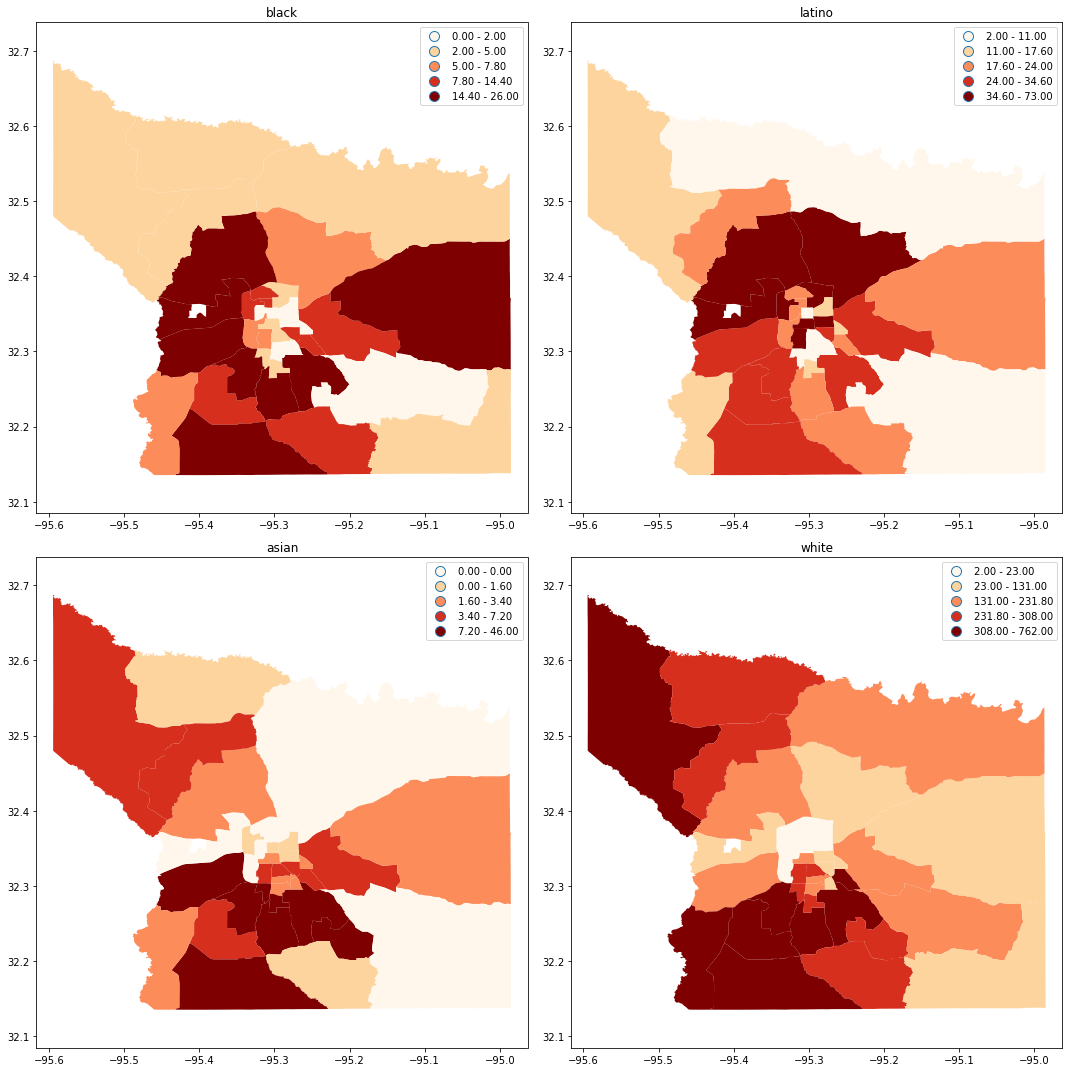

In [8]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts().get('Black', 0)

def latino(group_column):
    return group_column.value_counts().get('Latino', 0)

def asian(group_column):
    return group_column.value_counts().get('Asian', 0)

def white(group_column):
    return group_column.value_counts().get('White', 0)

def other(group_column):
    return group_column.value_counts().get('Other or N/A', 0)

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: What tracts have the highest proportion of loans for each race and ethnicity? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


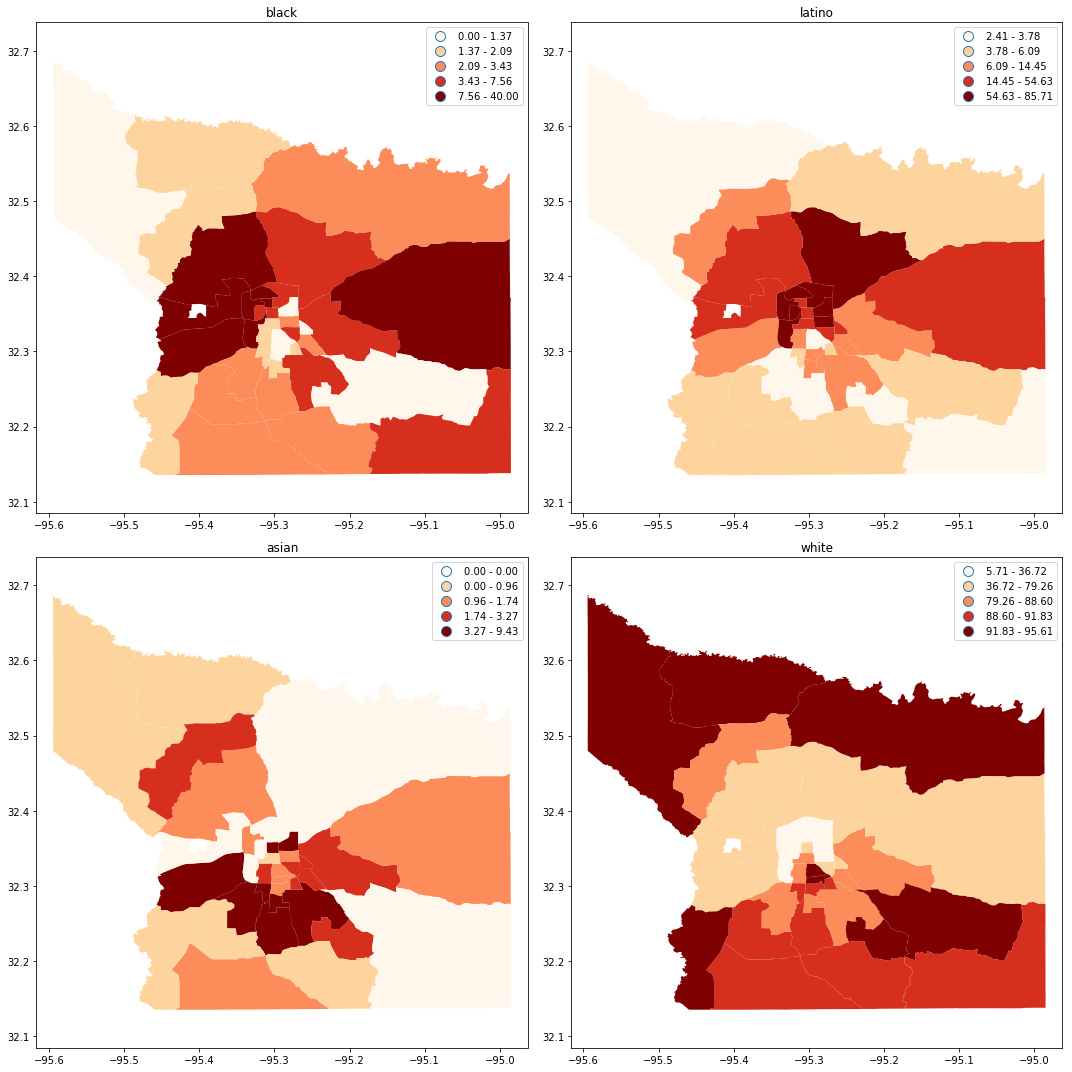

In [9]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'race_ethnicity': [black, latino, asian, white]
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='OrRd', scheme='Quantiles', legend=True)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: How are the share of black and Hispanic loans changing over time? (2010-2017)

/Users/onyxfish/.pyenv/versions/3.6.2/envs/tyler-home-loans/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


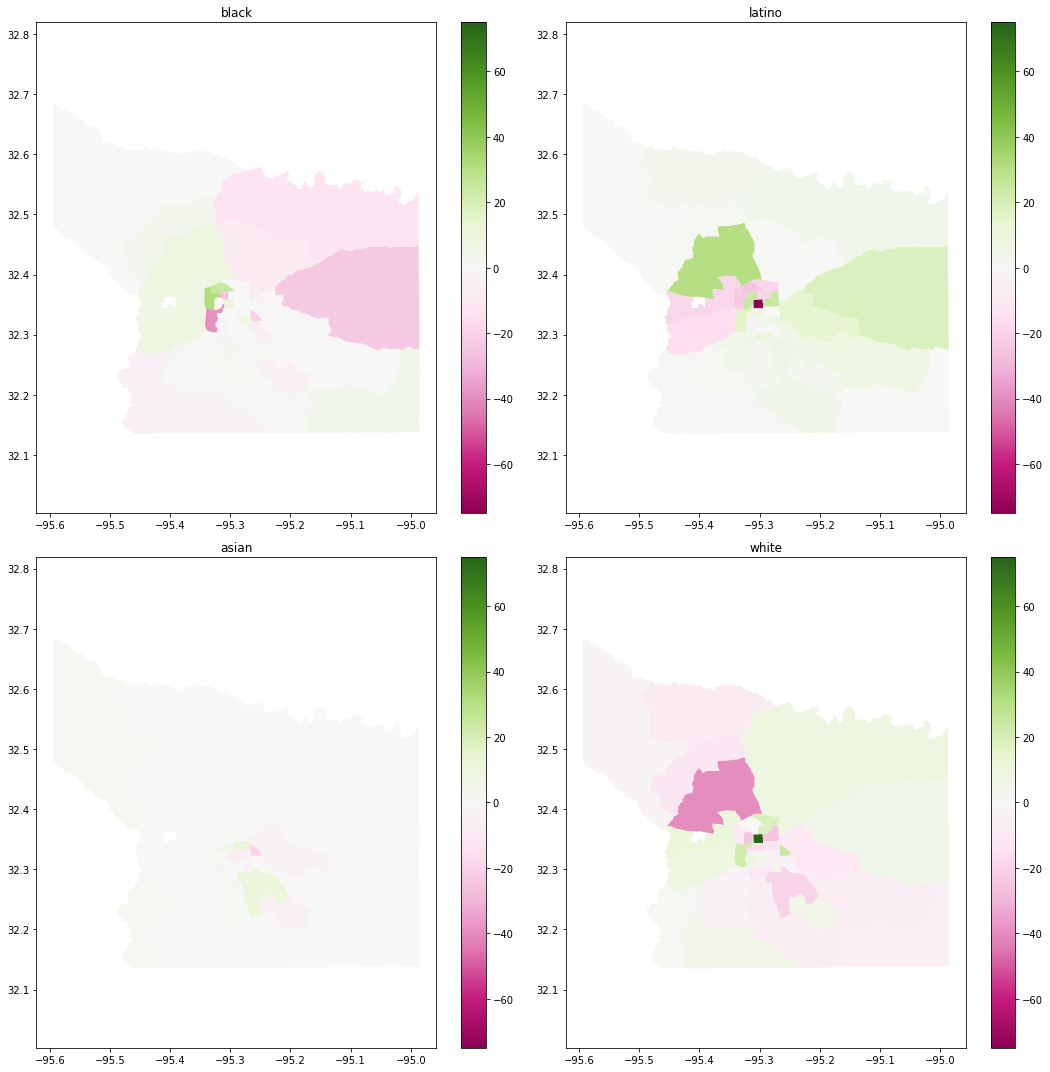

In [10]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

data = data.groupby(['census_tract_number_string', 'as_of_year'], as_index=False).agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

def change(group_column):
    return group_column.iat[-1] - group_column.iat[0]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    ('race_ethnicity', 'black'): change,
    ('race_ethnicity', 'latino'): change,
    ('race_ethnicity', 'asian'): change,
    ('race_ethnicity', 'white'): change
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

for i, group in enumerate(['black', 'latino', 'asian', 'white']):
    ax = plt.subplot(2, 2, i + 1)
    data.plot(column=('race_ethnicity', group), ax=ax, cmap='PiYG', legend=True, vmin=-75, vmax=75)
    ax.set_title(group)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Are there particular banks that appear to have higher or lower rates of denial for applicants of color? (2010-2017)

In [11]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def approved(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Loan originated', 0)

def denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0)

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby(['respondent_id', 'race_ethnicity'], as_index=False).agg({
    'action_taken_name': ['count', approved, denied, pct_denied]
})

data = data[data[('action_taken_name', 'count')] >= 20]
data = data[data['race_ethnicity'].isin(['Black', 'Latino'])]
data.sort_values(by=[('action_taken_name', 'count')], ascending=False).round(1)

respondent_id race_ethnicity action_taken_name                           
                                             count approved denied pct_denied
43     0000005581         Latino               222      197     25       11.3
99     0000013443         Latino               117      111      6        5.1
160    0000018297         Latino                99       65     34       34.3
698    83-0368926         Latino                89       85      4        4.5
159    0000018297          Black                32       13     19       59.4
205    0000024077         Latino                31       22      9       29.0
637    75-2725402         Latino                27       21      6       22.2
204    0000024077          Black                22       16      6       27.3

# Q: Which banks serve people of color? (2010-2017)

In [12]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def black(group_column):
    return group_column.value_counts(normalize=True).get('Black', 0) * 100

def latino(group_column):
    return group_column.value_counts(normalize=True).get('Latino', 0) * 100

def asian(group_column):
    return group_column.value_counts(normalize=True).get('Asian', 0) * 100

def white(group_column):
    return group_column.value_counts(normalize=True).get('White', 0) * 100

def other(group_column):
    return group_column.value_counts(normalize=True).get('Other or N/A', 0) * 100

data = data.groupby('respondent_id').agg({
    'race_ethnicity': ['count', black, latino, asian, white]
})

data = data[
    (data[('race_ethnicity', 'count')] >= 20) & (
        (data[('race_ethnicity', 'black')] > 15) |
        (data[('race_ethnicity', 'latino')] > 15)
    )
]
data.sort_values(by=('race_ethnicity', 'count'), ascending=False).round(1)

race_ethnicity                         
                       count black latino asian white
respondent_id                                        
0000005581               761   1.6   29.2   3.0  66.1
0000013443               532   1.3   22.0   1.3  74.8
83-0368926               109   3.7   81.7   0.0  14.7
0000697633                87   3.4   19.5   2.3  72.4
72-0506617                87  19.5   17.2   0.0  62.1
0000664756                53   0.0   15.1   5.7  79.2
0002590037                32   0.0   18.8   3.1  75.0
0000021074                26  15.4   26.9   0.0  57.7
0000703155                24  45.8    0.0   0.0  54.2
0000005288                22   4.5   22.7   0.0  68.2
0000018344                20   0.0   25.0  10.0  65.0

# Q: Has the likelihood of being approved as person of color changed over time? (2010-2017)

In [13]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

def pct_denied(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Application denied by financial institution', 0) / sum(counts) * 100

data = data.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'action_taken_name': ['count', pct_denied],
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean',
})

data

race_ethnicity as_of_year action_taken_name              \
                                           count  pct_denied   
0             Asian       2010                17   17.647059   
1             Asian       2011                16   25.000000   
2             Asian       2012                19   26.315789   
3             Asian       2013                35   14.285714   
4             Asian       2014                29   24.137931   
5             Asian       2015                43   13.953488   
6             Asian       2016                36   11.111111   
7             Asian       2017                42    7.142857   
8             Black       2010                45   44.444444   
9             Black       2011                21   19.047619   
10            Black       2012                40   57.500000   
11            Black       2013                39   20.512821   
12            Black       2014                47   27.659574   
13            Black       2015                47   36.170213   
14            Black       2016                52   19.230769   
15            Black       2017                63   15.873016   
16           Latino       2010                73   16.438356   
17           Latino       2011                97   18.556701   
18           Latino       2012               108   21.296296   
19           Latino       2013               125   19.200000   
20           Latino       2014               137   23.357664   
21           Latino       2015               142   13.380282   
22           Latino       2016               153   23.529412   
23           Latino       2017               177   17.514124   
24  Native American       2010                 5   40.000000   
25  Native American       2011                 3   33.333333   
26  Native American       2012                14    7.142857   
27  Native American       2013                 8    0.000000   
28  Native American       2014                 6   16.666667   
29  Native American       2015                 2   50.000000   
30  Native American       2016                 5   20.000000   
31  Native American       2017                 7   14.285714   
32  Native Hawaiian       2011                 1    0.000000   
33  Native Hawaiian       2012                 1  100.000000   
34  Native Hawaiian       2013                 3    0.000000   
35  Native Hawaiian       2014                 2    0.000000   
36  Native Hawaiian       2015                 2    0.000000   
37  Native Hawaiian       2016                 2    0.000000   
38  Native Hawaiian       2017                 6    0.000000   
39            White       2010               844   11.255924   
40            White       2011               804   10.820896   
41            White       2012               931   12.996778   
42            White       2013              1152   12.065972   
43            White       2014              1215    8.724280   
44            White       2015              1289    9.387122   
45            White       2016              1296    9.413580   
46            White       2017              1361    8.376194   

   applicant_income_000s loan_amount_000s  
                    mean             mean  
0             116.705882       198.705882  
1             102.214286       205.125000  
2             118.000000       189.526316  
3             126.371429       200.742857  
4              97.758621       178.896552  
5             112.627907       230.093023  
6             168.583333       231.583333  
7             141.952381       234.904762  
8              90.711111       135.266667  
9             110.238095       167.190476  
10             76.700000       134.925000  
11             99.435897       185.769231  
12             77.744681       150.851064  
13             79.630435       149.382979  
14            112.500000       233.942308  
15             83.145161       188.904762  
16             67.931507        92.849315  
17             56.268041        

# Q: Are there census tracts with exceptionally few or many loans? (2010-2017)

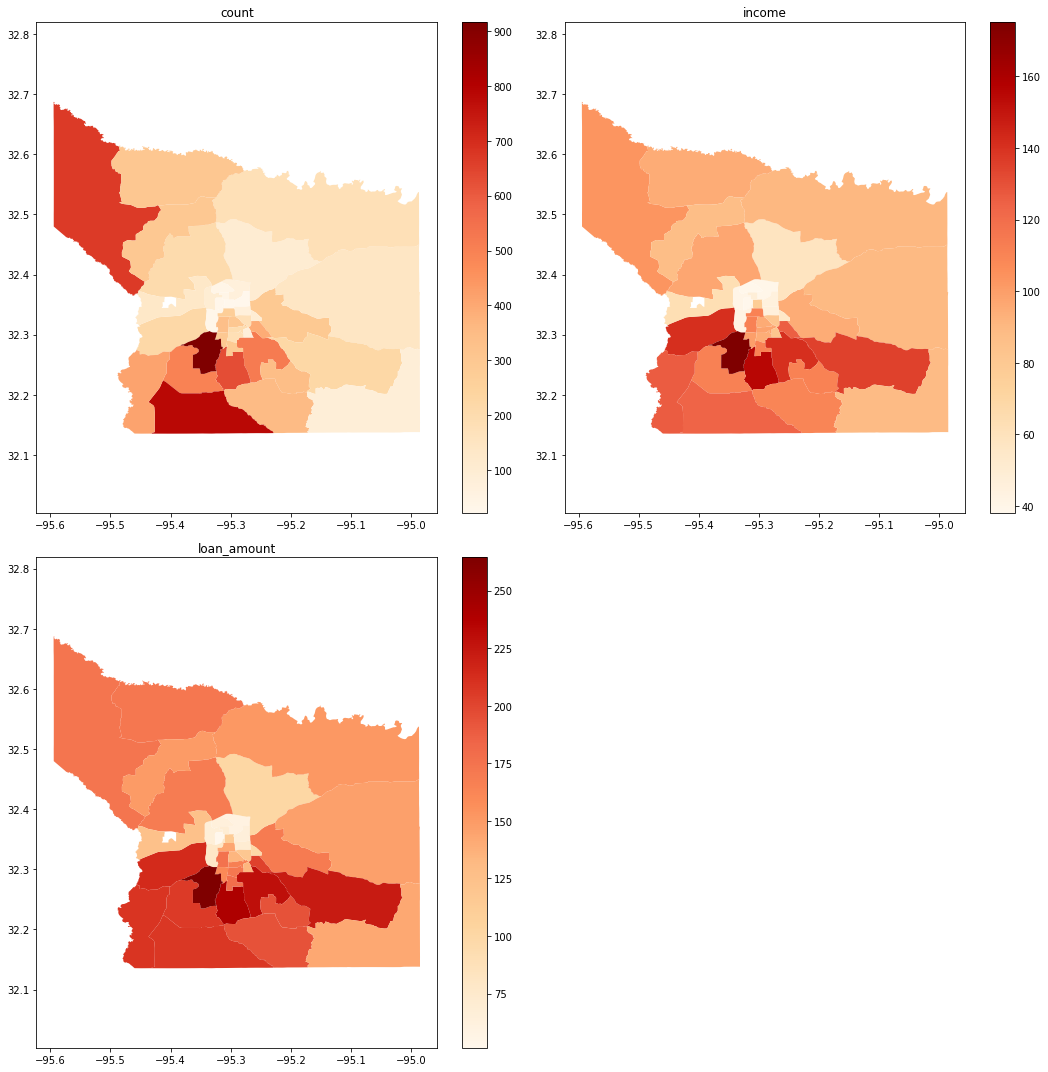

In [14]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.groupby('census_tract_number_string', as_index=False).agg({
    'state_name': 'count',
    'applicant_income_000s': 'mean',
    'loan_amount_000s': 'mean'
})

data = tract_geos.merge(data, left_on='TRACTCE', right_on='census_tract_number_string')

plt.figure(figsize=(15, 15))

ax = plt.subplot(2, 2, 1)
data.plot(column='state_name', ax=ax, cmap='OrRd', legend=True)
ax.set_title('count')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 2)
data.plot(column='applicant_income_000s', ax=ax, cmap='OrRd', legend=True)
ax.set_title('income')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 3)
data.plot(column='loan_amount_000s', ax=ax, cmap='OrRd', legend=True)
ax.set_title('loan_amount')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Is there statistical evidence of bias against applicants of color? (Reveal, 2010-2017)

In [15]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.merge(enriched_census, on='census_tract_number_string')

X = pd.concat([
    # Reference variable: White
    pd.Series(data['race_ethnicity'] == 'Black', name='Black', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Latino', name='Latino', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Asian', name='Asian', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Native American', name='Native American', dtype='int'),
    pd.Series(data['race_ethnicity'] == 'Native Hawaiian', name='Native Hawaiian', dtype='int'),
    pd.Series(data['race_ethnicity'].isna(), name='Race N/A', dtype='int'),
    # Reference variable: Female
    pd.Series(data['applicant_sex_name'] == 'Male', name='Male', dtype='int'),
    pd.Series(data['applicant_sex_name'].isna(), name='Sex N/A', dtype='int'),
    pd.Series(data['co_applicant_sex_name'].isin(['Male', 'Female']), name='Co-applicant', dtype='int'),
    pd.Series(data['co_applicant_sex_name'].isna(), name='Co-applicant N/A', dtype='int'),
    pd.Series(np.log(data['loan_amount_000s']), name='Log of loan'),
    pd.Series(np.log(data['applicant_income_000s']), name='Log of income'),
    pd.Series(data['loan_amount_000s'] / data['applicant_income_000s'], name='Loan-to-income ratio'),
    pd.Series(data['tract_to_msamd_income'], name='Tract-MSA median income ratio'),
    pd.Series(data['percent_black'], name='Percent black in tract'),
    pd.Series(data['percent_latino'], name='Percent Latino in tract'),
    pd.Series(data['percent_asian'], name='Percent Asian in tract'),
    pd.Series(data['percent_native_american'], name='Percent Native American in tract'),
    pd.Series(data['percent_native_hawaiian'], name='Percent Native Hawaiian in tract'),
    # Reference variable: FDIC
    pd.Series(data['agency_abbr'] == 'OCC', name='OCC', dtype='int'),
    pd.Series(data['agency_abbr'] == 'FRS', name='FRS', dtype='int'),
    pd.Series(data['agency_abbr'] == 'NCUA', name='NCUA', dtype='int'),
    pd.Series(data['agency_abbr'] == 'HUD', name='HUD', dtype='int'),
    pd.Series(data['agency_abbr'] == 'CFPB', name='CFPB', dtype='int'),
    pd.Series(data['agency_abbr'] == 'OTS', name='OTS', dtype='int'),
#     pd.Series(data['as_of_year'], name='Year'),
    # Reference: all banks with fewer than 500 loans
    pd.Series(data['respondent_id'] == '0000005581', name='Austin Bank', dtype='int'),
    pd.Series(data['respondent_id'] == '0000013443', name='Citizen\'s National Bank', dtype='int'),
    pd.Series(data['respondent_id'] == '0000018297', name='Southside Bank', dtype='int'),
    pd.Series(data['respondent_id'] == '0000017842', name='Texas Bank', dtype='int'),
    pd.Series(data['respondent_id'] == '0000024077', name='Altra Federal Credit Union', dtype='int'),
    pd.Series(data['respondent_id'] == '75-2725402', name='NTFN', dtype='int'),
    pd.Series(data['respondent_id'].isin(['0000013044', '0000480228']), name='Bank of America', dtype='int'),
], axis=1)

y = pd.Series(data['action_taken_name'] == 'Application denied by financial institution', name='Denied', dtype='int')

logit = sm.Logit(y, X, missing='drop')
result = logit.fit()

result.summary()

# np.exp(result.params)

Optimization terminated successfully.
         Current function value: 0.334257
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Denied   No. Observations:                10256
Model:                          Logit   Df Residuals:                    10224
Method:                           MLE   Df Model:                           31
Date:                Sat, 28 Jul 2018   Pseudo R-squ.:                 0.09252
Time:                        21:16:14   Log-Likelihood:                -3428.1
converged:                       True   LL-Null:                       -3777.7
                                        LLR p-value:                3.781e-127
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Black                                0.9300      0.143      6.523      0.000       0.651       1.210
Latino                               0.1203      0.114      1.053      0.292      -0.104       0.344
Asian                                0.6347      0.201      3.165      0.002       0.242       1.028
Native American                      0.5738      0.429      1.338      0.181      -0.267       1.414
Native Hawaiian                     -0.2056      1.040     -0.198      0.843      -2.243       1.832
Race N/A                             0.2414      0.202      1.193      0.233      -0.155       0.638
Male                                 0.0367      0.077      0.479      0.632      -0.113       0.187
Sex N/A                              0.3959      0.272      1.455      0.146      -0.137       0.929
Co-applicant                         0.0248      0.071      0.351      0.726      -0.114       0.164
Co-applicant N/A                     0.1730      0.254      0.680      0.496      -0.325       0.671
Log of loan                         -0.6316      0.106     -5.960      0.000      -0.839      -0.424
Log of income                        0.1147      0.105      1.088      0.277      -0.092       0.321
Loan-to-income ratio                 0.4002      0.050      7.964      0.000       0.302       0.499
Tract-MSA median income ratio       -0.0045      0.001     -3.176      0.001      -0.007      -0.002
Percent black in tract               0.0061      0.003      1.876      0.061      -0.000       0.012
Percent Latino in tract             -0.0002      0.003     -0.055      0.956      -0.006       0.006
Percent Asian in tract              -0.1316      0.022     -6.005      0.000      -0.175      -0.089
Percent Native American in tract     0.0476      0.070      0.678      0.498      -0.090       0.185
Percent Native Hawaiian in tract     0.0894      0.090      0.995      0.320      -0.087       0.265
OCC                                  0.3919      0.162      2.421      0.015       0.075       0.709
FRS                                 -0.0791      0.192     -0.411      0.681      -0.456       0.298
NCUA                                 0.1058      0.196      0.540      0.589      -0.278       0.490
HUD                                 -0.0628      0.148     -0.425      0.671      -0.352       0.227
CFPB                                 0.7346      0.150      4.913      0.000       0.442       1.028
OTS                                  0.6935      0.361      1.921      0.055      -0.014       1.401
Austin Bank                         -0.2191      0.151     -1.448      0.148      -0.516       0.078
Citizen's National Bank             -0.5484      0.189     -2.902      0.004      -0.919      -0.178
Southside Bank                       0.8594      0.157      5.490      0.000       0.553       1.166
Texas Bank                           0.3408      0.200      1.701      0.089      -0.052       0.733
Altra Fed

# Q: Are there banks which are obviously redlining?

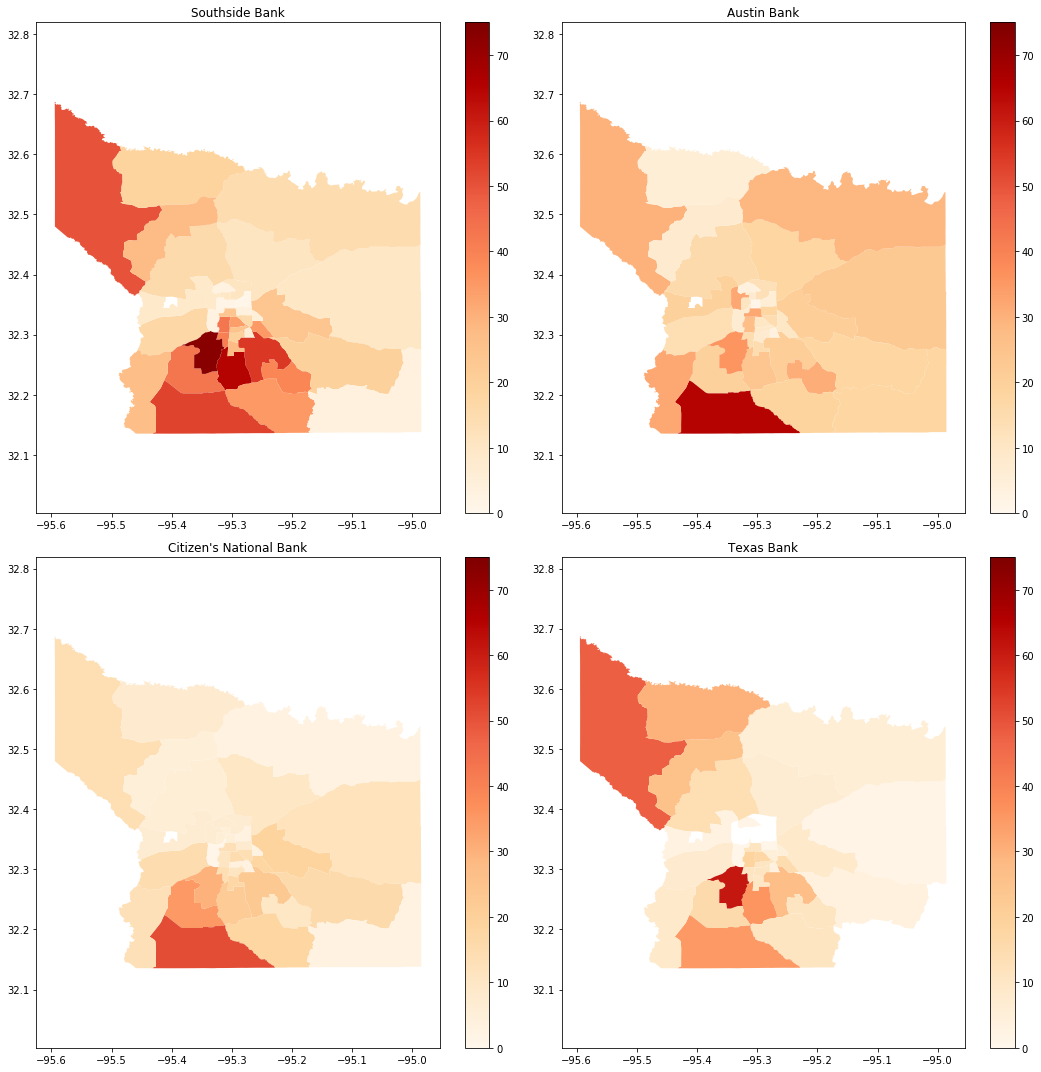

In [32]:
data = filtered_hmda[filtered_hmda['as_of_year'] >= 2010]

data = data.groupby(['respondent_id', 'census_tract_number_string'], as_index=False).agg({
    'state_name': 'count'
})

data = tract_geos.merge(data, how='right', left_on='TRACTCE', right_on='census_tract_number_string')

banks = data.groupby('respondent_id')

plt.figure(figsize=(15, 15))

ax = plt.subplot(2, 2, 1)
banks.get_group('0000018297').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Southside Bank')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 2)
banks.get_group('0000005581').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Austin Bank')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 3)
banks.get_group('0000013443').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Citizen\'s National Bank')
ax.set_aspect('equal', adjustable='datalim')

ax = plt.subplot(2, 2, 4)
banks.get_group('0000017842').plot(column='state_name', ax=ax, cmap='OrRd', legend=True, vmin=0, vmax=75)
ax.set_title('Texas Bank')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

# Q: Are black Tylerites mortgaging their houses for cash?

In [39]:
data = enriched_hmda[enriched_hmda['as_of_year'] >= 2010]

data = data[
    (data['loan_type_name'] == 'Conventional') &
    (data['property_type_name'] == 'One-to-four family dwelling (other than manufactured housing)') &
    (data['owner_occupancy_name'] == 'Owner-occupied as a principal dwelling') &
    (data['action_taken_name'].isin(['Loan originated', 'Application denied by financial institution'])) &
    (data['loan_amount_000s'] < 90000) &
    (data['applicant_income_000s'] != 9999)
]

def purchase(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Home purchase', 0)

def refinance(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Refinancing', 0)

def home_improvement(group_column):
    counts = group_column.value_counts()
    
    return counts.get('Home improvement', 0)

data = data.groupby(['race_ethnicity', 'as_of_year'], as_index=False).agg({
    'loan_purpose_name': ['count', purchase, refinance, home_improvement]
})

data.round(1)

race_ethnicity as_of_year loan_purpose_name                     \
                                           count purchase refinance   
0             Asian       2010                57       17        38   
1             Asian       2011                58       16        39   
2             Asian       2012                60       19        36   
3             Asian       2013                64       35        27   
4             Asian       2014                43       29        11   
5             Asian       2015                67       43        21   
6             Asian       2016                52       36        16   
7             Asian       2017                59       42        13   
8             Black       2010               187       45        92   
9             Black       2011               137       21        77   
10            Black       2012               203       40       111   
11            Black       2013               290       39       147   
12            Black       2014               218       47       114   
13            Black       2015               238       47       128   
14            Black       2016               274       52       145   
15            Black       2017               282       63       123   
16           Latino       2010               257       73       115   
17           Latino       2011               238       97       100   
18           Latino       2012               319      108       151   
19           Latino       2013               329      125       139   
20           Latino       2014               305      137       115   
21           Latino       2015               324      142       131   
22           Latino       2016               327      153       119   
23           Latino       2017               343      177       113   
24  Native American       2010                16        5        11   
25  Native American       2011                20        3        11   
26  Native American       2012                29       14        12   
27  Native American       2013                20        8        10   
28  Native American       2014                14        6         6   
29  Native American       2015                 9        2         6   
30  Native American       2016                16        5        10   
31  Native American       2017                16        7         8   
32  Native Hawaiian       2010                 6        0         5   
33  Native Hawaiian       2011                 4        1         0   
34  Native Hawaiian       2012                 4        1         2   
35  Native Hawaiian       2013                 8        3         4   
36  Native Hawaiian       2014                 6        2         2   
37  Native Hawaiian       2015                 5        2         3   
38  Native Hawaiian       2016                 4        2         2   
39  Native Hawaiian       2017                 8        6         2   
40            White       2010              2867      844      1716   
41            White       2011              2699      804      1606   
42            White       2012              3115      931      1897   
43            White       2013              3076     1152      1576   
44            White       2014              2388     1215       895   
45            White       2015              2571     1289      1007   
46            White       2016              2768     1296      1138   
47            White       2017              2407     1361       740   

                     
   home_improvement  
0                 2  
1                 3  
2                 5  
3                 2  
4                 3  
5                 3  
6                 0  
7                 4  
8                50  
9                39  
10               52  
11              104  
12               57  
13               63  
14               77  
15               96  
16               69  
17               41  
18            